In [17]:
from rasterization import rasterize_batch
from dataloaders import context_description, CustomImageDataset, d_collate_fn
import matplotlib.pylab as plt
from tqdm import tqdm

In [12]:
from six.moves import cPickle as pickle 

def save_dict(di_, filename_):
    with open(filename_, 'ab') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    out_d = {}
    with open(filename_, 'rb') as f:
        try:
            while(1):
                loaded_dict = pickle.load(f)
                out_d = {**out_d, **loaded_dict}
        except EOFError:
            pass

    return out_d

## Loaders

In [3]:
import os
dir_data = '/media/robot/hdd/waymo_dataset/tf_example'
train_tfrecord_path = os.path.join(dir_data, "training/training_tfexample.*-of-01000")

train_dataset = CustomImageDataset(train_tfrecord_path, context_description)
import torch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                           num_workers=0, collate_fn=d_collate_fn)

train dataset containing 5 files


In [4]:
tli = iter(train_loader)
data = next(tli)

/media/robot/hdd/waymo-open-dataset-repo/tutorial/test/dataloaders.py:225: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return d_collate_fn([torch.as_tensor(b) for b in batch])


In [5]:
rasterized = rasterize_batch(data, True)

## Renderer class

In [979]:
class RgbRenderer():
    def __init__(self, index_path="rendered/index.pkl", rgb_file_name_base="rendered/rgb"):
        self.index_path = index_path
        self.rgb_file_name_base = rgb_file_name_base
    
    
    def save_dict(self, di_, filename_= None):
        if filename_ is None:
            filename_ = self.index_path
        with open(filename_, 'ab') as f:
            pickle.dump(di_, f)

 
    def save_dataset(self, loader, index_file_name=None, rgb_file_name_base=None, ):
        if index_file_name is None:
            index_file_name = self.index_path
        if rgb_file_name_base is None:
            rgb_file_name_base = self.rgb_file_name_base
            
        rgb_file_name_index = 0
        #rgb_holder = np.random.rand(0, 224, 224, 3)
        rgb_holder = {}

        index_dict = {}
        
        tli = iter(train_loader)
        for data in tqdm(tli):
            rasterized, d = self.create_rasters(data, rgb_file_name_base+str(rgb_file_name_index)+".npz")
            index_dict = {**d, **index_dict}
            #rgb_holder = np.concatenate([rgb_holder, rasterized])
            
            
            rgb_holder = {**rgb_holder, **rasterized}
            if len(rgb_holder)>= 200:
                np.savez(rgb_file_name_base+str(rgb_file_name_index), rgb=rgb_holder, names=np.array(list(index_dict.keys())))
                rgb_file_name_index += 1
                rgb_holder = {}
                self.save_dict(index_dict, index_file_name)
                index_dict = {}
        self.save_dict(index_dict, index_file_name)
        np.savez(rgb_file_name_base+str(rgb_file_name_index), rgb=rgb_holder, names=np.array(list(index_dict.keys()))) 
        return

    
    def get_rgbgilenames_from_batch(self, data):
        batch = data['scenario/id']
        try:
            scenario_ids = [sc.numpy().tobytes().decode("utf-8") for sc in batch]
        except:
            scenario_ids = batch
        (data["state/tracks_to_predict"]>0).nonzero()
        mask = (data["state/tracks_to_predict"]>0)
        scenarios_id = []
        for bn, scenario in enumerate(scenario_ids):
            [scenarios_id.append(scenario) for i in range((mask.nonzero()[:, 0] == bn).sum())]

        aids = data["state/id"][mask]
        names = [scenarios_id[i]+str(aids[i].item()) for i in range(len(aids))]
        return names

    def create_rasters(self, data, file_ind):
        
        rasterized = rasterize_batch(data, True)
        summed_cur = np.concatenate(rasterized)[:,:,:,3:14].sum(-1)
        summed_neigh = np.concatenate(rasterized)[:,:,:,14:].sum(-1)
        rgb = np.concatenate(rasterized)[:,:,:,:3]
        rgb[:,:,:,1] += -np.clip(summed_cur, 0,200)
        rgb[:,:,:,1] = np.clip(rgb[:,:,:,1], 0 ,255)
        rgb[:,:,:,0] += -np.clip(summed_neigh, 0,200)
        rgb[:,:,:,0] = np.clip(rgb[:,:,:,0], 0 ,255)

        # prepare SIDs and AIDs
        names = self.get_rgbgilenames_from_batch(data)
        for_indexing = {}

        for name in names:
            for_indexing[name] = file_ind
        out_rgb = {}
        for i, name in enumerate(names):
            out_rgb[name] = 255-rgb[i:i+1]

        return out_rgb, for_indexing



In [980]:
# to_save = {1: np.random.rand(224,224,3), 2: np.random.rand(224,224,3)}
# np.savez( "temp", a=to_save)

In [981]:
path = "/media/robot/hdd/waymo-open-dataset-repo/tutorial/test/rendered/rgb0.npz"
np.load(path, allow_pickle=True)["rgb"].reshape(-1)[0]["c1c150ffee89f90d3.0"].shape

FileNotFoundError: [Errno 2] No such file or directory: '/media/robot/hdd/waymo-open-dataset-repo/tutorial/test/rendered/rgb0.npz'

In [983]:
rgb_rend = RgbRenderer()
rgb_rend.save_dataset(train_loader)

0it [00:02, ?it/s]


KeyboardInterrupt: 

## Loader class

In [49]:
class RgbLoader():
    def __init__(self, index_path="rendered/index.pkl"):
        self.index_path = index_path
        self.index_dict = self.load_dict()
        self.opened_files = {}
        self.rgbs = {}

    def load_dict(self, filename_=None):
        if filename_ is None:
            filename_ = self.index_path

        out_d = {}
        with open(filename_, 'rb') as f:
            try:
                while(1):
                    loaded_dict = pickle.load(f)
                    out_d = {**out_d, **loaded_dict}
            except EOFError:
                pass
        return out_d
    
    
    def namefile_to_file_name_index(self, names, files):
        out_files = {}
#         print(f"names: {names}")
#         print(f"files: {files}")
        for i, (name, file) in enumerate(zip(names, files)):
            if file in out_files:
                out_files[file].append([name, i])
            else:
                out_files[file] = [[name, i]]
        return out_files


    def load_batch_rgb(self, data):
        batch = data['scenario/id']
        try:
            scenario_ids = [sc.numpy().tobytes().decode("utf-8") for sc in batch]
        except:
            scenario_ids = batch
        mask = (data["state/tracks_to_predict"]>0)
        scenarios_id = []
        for bn, scenario in enumerate(scenario_ids):
            [scenarios_id.append(scenario) for i in range((mask.nonzero()[:, 0] == bn).sum())]

        aids = data["state/id"][mask]
        names = [scenarios_id[i]+str(aids[i].item()) for i in range(len(aids))]
        files = [self.index_dict[name] for name in names]
        file_name_index = self.namefile_to_file_name_index(names, files)
        batch_rgb = np.random.rand(len(aids), 224, 224, 3)
        for file,  name_index in file_name_index.items():
            indexes = [ni[1] for ni in name_index]
            batch_rgb[indexes] = self.load_rgb_by_name_file(name_index, file)
        return batch_rgb

    def load_rgb_by_name_file(self, name_index, file_path):
        if file_path not in self.opened_files:
            self.opened_files[file_path] = 1
            self.rgbs = {**self.rgbs, **np.load(file_path, allow_pickle=True)["rgb"].reshape(-1)[0]}
        import time
        st = time.time()

        out =[] 
        for n_i in name_index:
            out.append(self.rgbs[n_i[0]])
        out = np.concatenate([out])
        return out[:,0]

## Tests

In [50]:

loader = RgbLoader()

In [51]:
import numpy as np

In [63]:
def test_load(loader, tli):
    for i, data in enumerate(tqdm(tli)):
        try:
            rgb_batch = loader.load_batch_rgb(data)
        except Exception as e:
            print (e)
            raise(e)
            continue

        mask = (data["state/tracks_to_predict"]>0)
        aids = data["state/id"][mask]
        if i > 20:
            break

In [68]:
tli = iter(train_loader)

In [69]:
for i, data in enumerate(tqdm(tli)):
        try:
            rgb_batch = loader.load_batch_rgb(data)
        except Exception as e:
            print (e)
            raise(e)
            continue

        mask = (data["state/tracks_to_predict"]>0)
        aids = data["state/id"][mask]
        if i > 20:
            break

3it [00:02,  1.28it/s]


KeyboardInterrupt: 

In [72]:
# plt.imshow(rgb_batch[0])

NameError: name 'rgb_batch' is not defined

In [828]:
%load_ext line_profiler


In [846]:
# %lprun -T lprof0 -f loader.load_batch_rgb(data) loader.load_batch_rgb(data)



*** Profile printout saved to text file 'lprof0'. 


In [56]:
%prun loader.load_batch_rgb(data)


In [58]:
# %prun next(tli)

In [847]:
print(open('lprof0', 'r').read())


Timer unit: 1e-06 s


In [522]:
def create_rasters(data, file_ind):

    rasterized = rasterize_batch(data, True)
    summed_cur = np.concatenate(rasterized)[:,:,:,3:14].sum(-1)
    summed_neigh = np.concatenate(rasterized)[:,:,:,14:].sum(-1)
    rgb = np.concatenate(rasterized)[:,:,:,:3]
    # print(rgb[:,:,1].max())
    rgb[:,:,:,1] += -np.clip(summed_cur, 0,200)
    rgb[:,:,:,0] += -np.clip(summed_neigh, 0,200)
    
    # prepare SIDs and AIDs
    batch = data['scenario/id']
    try:
        scenario_ids = [sc.numpy().tobytes().decode("utf-8") for sc in batch]
    except:
        scenario_ids = batch
    (data["state/tracks_to_predict"]>0).nonzero()
    mask = (data["state/tracks_to_predict"]>0)
    scenarios_id = []
    for bn, scenario in enumerate(scenario_ids):
        [scenarios_id.append(scenario) for i in range((mask.nonzero()[:, 0] == bn).sum())]
    
    aids = data["state/id"][mask]
    names = [scenarios_id[i]+str(aids[i].item()) for i in range(len(aids))]
    for_indexing = {}
    
    for name in names:
        for_indexing[name] = file_ind
    
    
    return rgb, for_indexing

In [523]:
from tqdm import tqdm

In [561]:
def save_dataset():
    index_file_name = "rendered/index.pkl"
    rgb_file_name_base = "rendered/rgb"
    rgb_file_name_index = 0

    rgb_holder = np.random.rand(0, 224, 224, 3)

    index_dict = {}
    for i in tqdm(range(20)):
        data = next(tli)

        rasterized, d = create_rasters(data, rgb_file_name_base+str(rgb_file_name_index)+".npz")
        index_dict = {**d, **index_dict}

        rgb_holder = np.concatenate([rgb_holder, rasterized])
        if rgb_holder.shape[0]>= 100:
            np.savez_compressed(rgb_file_name_base+str(rgb_file_name_index), rgb=rgb_holder, names=np.array(list(index_dict.keys())))
            rgb_file_name_index += 1
            rgb_holder = np.random.rand(0, 224, 224, 3)
            save_dict(index_dict, index_file_name)
            index_dict = {}
    save_dict(index_dict, index_file_name)
    np.savez_compressed(rgb_file_name_base+str(rgb_file_name_index), rgb=rgb_holder, names=np.array(list(index_dict.keys())))

In [562]:
def load_rgbs_by_name(names, d):
        file_pathes = [d[name], for name in names]
        np.load(file_path)
        ind = np.where(out["names"] == '30e853fc0e61ebfe2708.0')[0]
        out["rgb"][ind]

In [563]:
save_dataset()

100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


In [564]:
index_file_name = "rendered/index.pkl"
d = load_dict(index_file_name)

In [565]:
d

{'f543c8b0a34e62711830.0': 'rendered/rgb0.npz',
 'f543c8b0a34e62711831.0': 'rendered/rgb0.npz',
 'f543c8b0a34e62711833.0': 'rendered/rgb0.npz',
 'f543c8b0a34e62711836.0': 'rendered/rgb0.npz',
 'f543c8b0a34e62711837.0': 'rendered/rgb0.npz',
 'f543c8b0a34e62711847.0': 'rendered/rgb0.npz',
 'f543c8b0a34e62711872.0': 'rendered/rgb0.npz',
 'f543c8b0a34e62711880.0': 'rendered/rgb0.npz',
 '30e853fc0e61ebfe1081.0': 'rendered/rgb0.npz',
 '30e853fc0e61ebfe1084.0': 'rendered/rgb0.npz',
 '30e853fc0e61ebfe1086.0': 'rendered/rgb0.npz',
 '30e853fc0e61ebfe2708.0': 'rendered/rgb0.npz',
 'b23fe709bb910e1a138.0': 'rendered/rgb0.npz',
 'b23fe709bb910e1a167.0': 'rendered/rgb0.npz',
 'b23fe709bb910e1a201.0': 'rendered/rgb0.npz',
 '32ecb5accb4b22b5516.0': 'rendered/rgb0.npz',
 '32ecb5accb4b22b5519.0': 'rendered/rgb0.npz',
 '32ecb5accb4b22b5522.0': 'rendered/rgb0.npz',
 '32ecb5accb4b22b5526.0': 'rendered/rgb0.npz',
 '32ecb5accb4b22b5537.0': 'rendered/rgb0.npz',
 '32ecb5accb4b22b5542.0': 'rendered/rgb0.npz',
 

In [566]:
out = np.load("rendered/rgb0.npz")

In [578]:
dir(out)
ind = np.where(out["names"] == '30e853fc0e61ebfe2708.0')[0]
out["rgb"][ind]

(1, 224, 224, 3)

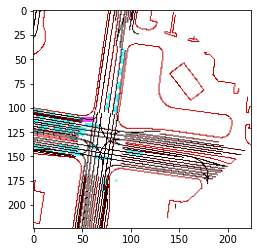

In [755]:
plt.imshow(rgb[9])

In [371]:
rgb[:,:,1] += np.clip(summed[:,:], 0,255)


In [499]:
data.keys()

dict_keys(['state/current/x', 'state/current/y', 'state/past/x', 'state/past/y', 'state/current/velocity_x', 'state/current/velocity_y', 'state/future/x', 'state/future/y', 'state/future/valid', 'state/current/valid', 'state/past/valid', 'state/tracks_to_predict', 'roadgraph_samples/xyz', 'scenario/id', 'state/past/vel_yaw', 'state/current/vel_yaw', 'state/past/bbox_yaw', 'state/current/bbox_yaw', 'state/id', 'state/type', 'roadgraph_samples/id', 'roadgraph_samples/type', 'roadgraph_samples/valid', 'traffic_light_state/current/valid', 'state/current/width', 'state/current/length', 'traffic_light_state/current/state'])

In [500]:
batch = data['scenario/id']
try:
    scenario_ids = [sc.numpy().tobytes().decode("utf-8") for sc in batch]
except:
    scenario_ids = batch
scenario_ids

['8dc920a93e3cfc48', 'e9362ad4182819d5']

In [501]:
(data["state/tracks_to_predict"]>0).nonzero()
mask = (data["state/tracks_to_predict"]>0)
scenarios_id = []
for bn, scenario in enumerate(scenario_ids):
    [scenarios_id.append(scenario) for i in range((mask.nonzero()[:, 0] == bn).sum())]
scenarios_id

['8dc920a93e3cfc48',
 '8dc920a93e3cfc48',
 '8dc920a93e3cfc48',
 'e9362ad4182819d5']

In [502]:
aids = data["state/id"][mask]
print(scenarios_id)
print(aids)
aids.shape

['8dc920a93e3cfc48', '8dc920a93e3cfc48', '8dc920a93e3cfc48', 'e9362ad4182819d5']
tensor([  2.,  23.,  34., 688.])


torch.Size([4])

In [503]:
names = [scenarios_id[i]+str(aids[i].item()) for i in range(len(aids))]
names

['8dc920a93e3cfc482.0',
 '8dc920a93e3cfc4823.0',
 '8dc920a93e3cfc4834.0',
 'e9362ad4182819d5688.0']

In [287]:
def create_indexes_to_save(data, file_ind):
    batch = data['scenario/id']
    try:
        scenario_ids = [sc.numpy().tobytes().decode("utf-8") for sc in batch]
    except:
        scenario_ids  = batch
    mask = (data["state/tracks_to_predict"]>0)
    scenarios_id = []
    for bn, scenario in enumerate(scenario_ids):
        [scenarios_id.append(scenario) for i in range((mask.nonzero()[:, 0] == bn).sum())]
    aids = data["state/id"][mask]
    names = [scenarios_id[i]+str(aids[i].item()) for i in range(len(aids))]
    d = {}
    for name in names:
        d[name] = file_ind
    return d

In [297]:
images = np.
for i in range(1):
    data = next(tli)
    d = create_indexes_to_save(data, 0)
    index_file_name = "t.pkl"
    rasterized = rasterize_batch(data, True)
    save_dict(d, index_file_name)

In [298]:
d = load_dict(index_file_name)

In [299]:
d

{'818fad2d393e76171143.0': 0,
 '818fad2d393e76171153.0': 0,
 '818fad2d393e76171193.0': 0,
 '818fad2d393e76171202.0': 0,
 '818fad2d393e76171216.0': 0,
 '818fad2d393e76171547.0': 0,
 '9ebb6468d102b05c382.0': 0,
 '9ebb6468d102b05c384.0': 0,
 '9ebb6468d102b05c399.0': 0,
 '9ebb6468d102b05c461.0': 0,
 '9ebb6468d102b05c464.0': 0,
 '9ebb6468d102b05c476.0': 0,
 '1eca624640c764f017.0': 0,
 '1eca624640c764f036.0': 0,
 '1eca624640c764f054.0': 0,
 '1eca624640c764f056.0': 0,
 '1eca624640c764f060.0': 0,
 'a1271117c64408d2.0': 0,
 'a1271117c64408d3.0': 0,
 'a1271117c64408d9.0': 0,
 'a1271117c64408d11.0': 0,
 'a1271117c64408d35.0': 0,
 'b23fe709bb910e1a138.0': 0,
 'b23fe709bb910e1a167.0': 0,
 'b23fe709bb910e1a201.0': 0,
 '32ecb5accb4b22b5516.0': 0,
 '32ecb5accb4b22b5519.0': 0,
 '32ecb5accb4b22b5522.0': 0,
 '32ecb5accb4b22b5526.0': 0,
 '32ecb5accb4b22b5537.0': 0,
 '32ecb5accb4b22b5542.0': 0,
 'f543c8b0a34e62711830.0': 0,
 'f543c8b0a34e62711831.0': 0,
 'f543c8b0a34e62711833.0': 0,
 'f543c8b0a34e62711836.

0.03812488025624283

In [237]:
def create_random() -> dict :
    import random
    le = random.randint(2,7)
    out = {}
    for i in range(le):
        out[random.random()] = i
    return out


In [257]:
index_file_name = "t.pkl"
for i in range(10):
    d = create_random()
    with open(index_file_name, 'ab') as f:
        pickle.dump(d, f)
        
    #np.save(index_file_name, d)

In [258]:
out_d = {}
with open(index_file_name, 'rb') as f:
    
    try:
        while(1):
            loaded_dict = pickle.load(f)
            out_d = {**out_d, **loaded_dict}
    except EOFError:
        pass
    

In [259]:
out_d

{0.007261318036868913: 0,
 0.037928227577057605: 1,
 0.9486720375208744: 0,
 0.5206760749272671: 1,
 0.30129731982076613: 2,
 0.15523072529082338: 3,
 0.30877439874425827: 4,
 0.056176508404856995: 5,
 0.4813644832299008: 0,
 0.2944570399264418: 1,
 0.5378007569218293: 0,
 0.9827368469027629: 1,
 0.987151553830108: 0,
 0.997705109048276: 1,
 0.7796344133394135: 2,
 0.03415514456157953: 3,
 0.384936647117188: 4,
 0.6602100717961769: 5,
 0.46614648857212004: 0,
 0.3527773376159429: 1,
 0.9115816562585377: 2,
 0.9826266647062597: 0,
 0.06304823747855082: 1,
 0.8657285265999273: 2,
 0.6671370265989184: 3,
 0.04562791269693156: 4,
 0.2094996188433158: 0,
 0.6116114503125288: 1,
 0.8687266175793963: 2,
 0.2607980669178368: 3,
 0.912304590532815: 4,
 0.6244256209736815: 5,
 0.5427978039133203: 6,
 0.29661438567929277: 0,
 0.5440959629318984: 1,
 0.3308613230794578: 2,
 0.10611069665479866: 3,
 0.3976474868275637: 4,
 0.5521928793415248: 5,
 0.17541578450105133: 6,
 0.11856119471068782: 0,
 0.

In [196]:
index_dict

{'9a73810cd7874b1a709.0': 0,
 'f6c3d854a396ff8d767.0': 0,
 'f6c3d854a396ff8d788.0': 0,
 'f6c3d854a396ff8d790.0': 0,
 'f6c3d854a396ff8d797.0': 0,
 'f6c3d854a396ff8d799.0': 0}

In [193]:
with open(index_file_name+".npy", 'rb') as f:
    going = 1
    data = []
    while(going):
        try:
            data.append(np.load(f, allow_pickle=True))
        except:
            going = 0
#         b = np.load(f, allow_pickle=True)
# d = np.load(index_file_name+".npy", allow_pickle=True)

In [194]:
data

[array({'9a73810cd7874b1a709.0': 0, 'f6c3d854a396ff8d767.0': 0, 'f6c3d854a396ff8d788.0': 0, 'f6c3d854a396ff8d790.0': 0, 'f6c3d854a396ff8d797.0': 0, 'f6c3d854a396ff8d799.0': 0},
       dtype=object)]

In [142]:
save_dict(index_dict, index_file_name)

In [137]:
index_file_name

'index1.nz'

In [136]:
f = load_dict(index_file_name)
f#[names[0]]

{'da5e3fdff5d3be60661.0': 0,
 'da5e3fdff5d3be60671.0': 0,
 'da5e3fdff5d3be60689.0': 0,
 'dd5a4d2cd9f6a1251300.0': 0,
 'dd5a4d2cd9f6a1251301.0': 0,
 'dd5a4d2cd9f6a1251302.0': 0}